## Importing libraries

In [1]:
# Preprocessing Imports
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
# Model Imports
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
print(torch.cuda.is_available())       # Should be True
print(torch.cuda.get_device_name(0))   # Name of the GPU (e.g., Tesla T4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

True
Tesla T4


# Direct Inverse Control

## Phase 1

### Generate data

In [3]:
# Generate input - output data

def generate_xt(num_samples=10):
    x = np.random.uniform(-10, 10, num_samples) # Input random
    # x = np.random.randint(-10, 10, num_samples) # Input random

    t = np.zeros(num_samples)
    t[0] = 0
    for k in range(1, num_samples):
        t[k] = 1 / (1 + t[k-1]**2) + 0.25*x[k] - 0.3*x[k-1]

    df = pd.DataFrame({"x": x, "t": t})
    return df

df = generate_xt(30002)
print(df)

              x         t
0      7.398679  0.000000
1     -9.849548 -3.681991
2      6.676187  4.692606
3      2.203174 -1.408623
4     -9.435874 -2.684824
...         ...       ...
29997  2.724763  0.954421
29998  1.113597 -0.015721
29999  6.047516  2.177553
30000 -0.042085 -1.650613
30001 -2.450438 -0.331493

[30002 rows x 2 columns]


### Data Preprocessing

In [4]:
# Generate dataset from input output
df_lagged = pd.DataFrame({
    "t(t)"   : df["t"],
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "x(t-1)" : df["x"].shift(1),
    "x(t-2)" : df["x"].shift(2),
    "x(t)"   : df["x"]              # Target
})

df_lagged = df_lagged.dropna().reset_index(drop=True) # drop NaN values from first lagged rows

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

# Separate input and output
X = df_lagged[["t(t)", "t(t-1)", "t(t-2)", "x(t-1)", "x(t-2)"]].values   # input size=6
T = df_lagged[["x(t)"]].values    # target

# check size input and output
print(X.shape, T.shape)

       t(t)    t(t-1)    t(t-2)    x(t-1)    x(t-2)      x(t)
0  4.692606 -3.681991  0.000000 -9.849548  7.398679  6.676187
1 -1.408623  4.692606 -3.681991  6.676187 -9.849548  2.203174
2 -2.684824 -1.408623  4.692606  2.203174  6.676187 -9.435874
3  2.761965 -2.684824 -1.408623 -9.435874  2.203174 -0.762501
4  2.493289  2.761965 -2.684824 -0.762501 -9.435874  8.594570
(30000, 6)
(30000, 5) (30000, 1)


In [5]:
def split_dataset_seq(X, T):
    """
    Membagi dataset 30.000 sample secara berurutan:
    - Train: 15.000 pertama
    - Val: 5.000 terakhir dari train + 5.000 setelah train
    - Test: 10.000 terakhir
    """
    X_train = X[:15000]
    T_train = T[:15000]

    X_val = np.concatenate([X[10000:15000], X[15000:20000]])
    T_val = np.concatenate([T[10000:15000], T[15000:20000]])

    X_test = X[20000:]
    T_test = T[20000:]

    return X_train, T_train, X_val, T_val, X_test, T_test

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)


Train: (15000, 5) (15000, 1)
Val  : (10000, 5) (10000, 1)
Test : (10000, 5) (10000, 1)


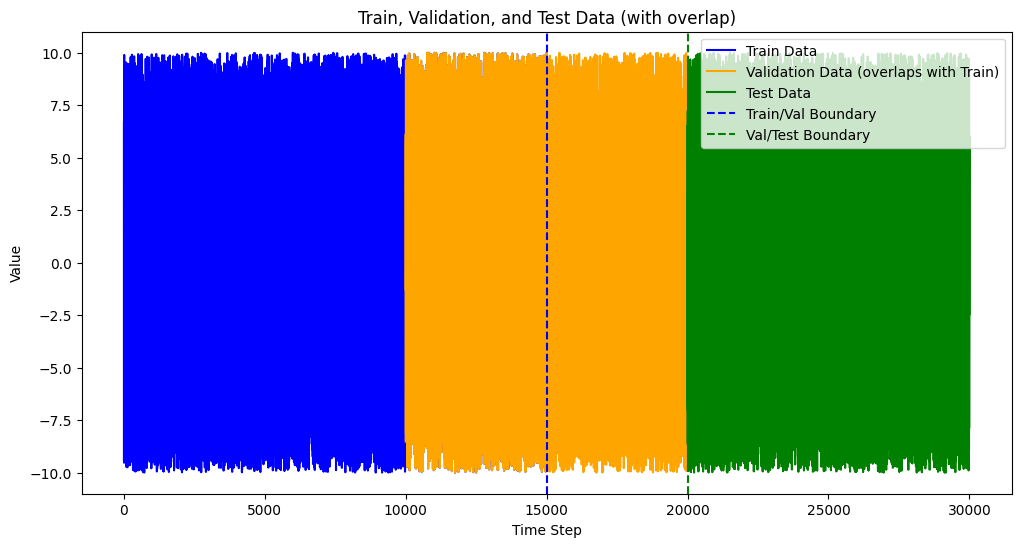

In [6]:
plt.figure(figsize=(12, 6))

# Define your index ranges explicitly
train_start, train_end = 0, 15000
val_start, val_end = 10000, 20000
test_start = 20000
test_end = test_start + len(T_test)

# Plot each segment with its corresponding x range
plt.plot(range(train_start, train_end), T_train, label='Train Data', color='blue')
plt.plot(range(val_start, val_end), T_val, label='Validation Data (overlaps with Train)', color='orange')
plt.plot(range(test_start, test_end), T_test, label='Test Data', color='green')

# Add vertical lines to indicate approximate boundaries
plt.axvline(x=train_end, color='b', linestyle='--', label='Train/Val Boundary')
plt.axvline(x=val_end, color='g', linestyle='--', label='Val/Test Boundary')

plt.legend()
plt.xlabel("Time Step")
plt.ylabel("Value")
plt.title("Train, Validation, and Test Data (with overlap)")

plt.show()

In [7]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [13]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### MLP Model

In [14]:
input_dim = X_train.shape[1]    # 5
output_dim = T_train.shape[1]   # 1

class MLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super().__init__()
    self.fc1 = nn.Linear(input_dim, 128)
    self.fc2 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 32)
    self.fc4 = nn.Linear(32, output_dim)
    self.tanh = nn.Tanh()
  def forward(self, x):
    x = self.tanh(self.fc1(x))
    x = self.tanh(self.fc2(x))
    x = self.tanh(self.fc3(x))
    x = self.fc4(x)
    return x

model = MLP(input_dim, output_dim).to(device)

### Training and Validation

In [15]:
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def train(model, optimizer, loss_fn, X_train, T_train, X_val, T_val,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            optimizer.zero_grad()
            pred = model(x)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                pred = model(x)
                loss = loss_fn(pred, t)
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, 'first_checkpoint.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        # if patience_ctr >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

        if train_loss < tol:
            # best_model_weights = model.state_dict()  # simpan di memory
            # torch.save(model.state_dict(), 'best_model.pt')
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, 'first_checkpoint.pt')
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")

    return history

history = train(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.005941, val MSE 0.003351
Epoch 1: train MSE 0.001116, val MSE 0.001646
Epoch 2: train MSE 0.000772, val MSE 0.000839
Epoch 3: train MSE 0.000600, val MSE 0.000455
Epoch 4: train MSE 0.000498, val MSE 0.001355
Epoch 5: train MSE 0.000431, val MSE 0.000868
Epoch 6: train MSE 0.000399, val MSE 0.000704
Epoch 7: train MSE 0.000345, val MSE 0.000813
Epoch 8: train MSE 0.000322, val MSE 0.000599
Epoch 9: train MSE 0.000299, val MSE 0.000789
Epoch 10: train MSE 0.000280, val MSE 0.000482
Epoch 11: train MSE 0.000267, val MSE 0.000365
Epoch 12: train MSE 0.000251, val MSE 0.000440
Epoch 13: train MSE 0.000235, val MSE 0.000439
Epoch 14: train MSE 0.000246, val MSE 0.000347
Epoch 15: train MSE 0.000211, val MSE 0.000444
Epoch 16: train MSE 0.000198, val MSE 0.000284
Epoch 17: train MSE 0.000197, val MSE 0.000374
Epoch 18: train MSE 0.000193, val MSE 0.000522
Epoch 19: train MSE 0.000186, val MSE 0.000409
Epoch 20: train MSE 0.000177, val MSE 0.000546
Epoch 21: train MSE 0.0

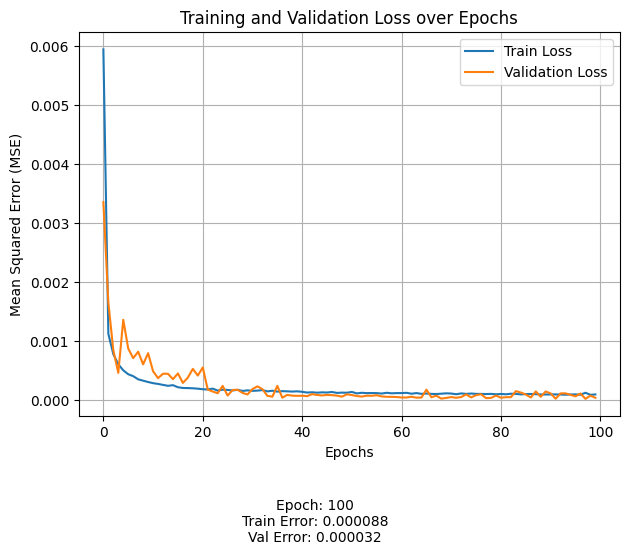

In [16]:
# Training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]

last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [17]:
checkpoint = torch.load('first_checkpoint.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [18]:
# Predictions
model.eval()
pred = []
with torch.no_grad():
  for i in range(len(Xtest)):
    x = Xtest[i]
    y_pred = model(x)
    pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (10000, 1)
type: <class 'numpy.ndarray'>, dim: (10000, 1)
[[ 6.5112004 ]
 [ 6.3548417 ]
 [ 4.243152  ]
 ...
 [ 6.1093407 ]
 [-0.04747246]
 [-2.435669  ]]
[[ 6.50940239]
 [ 6.34573165]
 [ 4.26809649]
 ...
 [ 6.04751612]
 [-0.04208463]
 [-2.45043779]]
mse test: 0.0014044038421919887


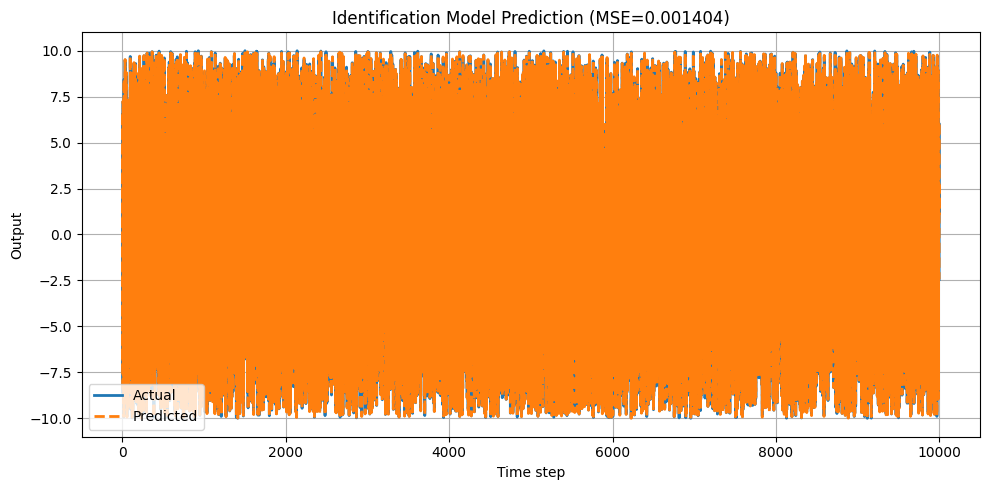

In [19]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Phase 2

### Data Preprocessing

In [20]:
# Generate dataset with lags
df_lagged = pd.DataFrame({
    "t(t)"   : df["t"],
    "t(t-1)" : df["t"].shift(1),
    "t(t-2)" : df["t"].shift(2),
    "x(t)"   : df["x"]
})

df_lagged = df_lagged.dropna().reset_index(drop=True)

# Check the dataset
print(df_lagged.head())
print(df_lagged.shape)

       t(t)    t(t-1)    t(t-2)      x(t)
0  4.692606 -3.681991  0.000000  6.676187
1 -1.408623  4.692606 -3.681991  2.203174
2 -2.684824 -1.408623  4.692606 -9.435874
3  2.761965 -2.684824 -1.408623 -0.762501
4  2.493289  2.761965 -2.684824  8.594570
(30000, 4)


In [28]:
# Separate input and output
X = df_lagged[["t(t)", "t(t-1)", "t(t-2)"]].values
T = df_lagged[["x(t)"]].values

# check size of dataset
print(X.shape, T.shape)

X_train, T_train, X_val, T_val, X_test, T_test = split_dataset_seq(X, T)
print("Train:", X_train.shape, T_train.shape)
print("Val  :", X_val.shape, T_val.shape)
print("Test :", X_test.shape, T_test.shape)

(30000, 3) (30000, 1)
Train: (15000, 3) (15000, 1)
Val  : (10000, 3) (10000, 1)
Test : (10000, 3) (10000, 1)
[[ 4.69260631 -3.68199066  0.        ]
 [-1.4086232   4.69260631 -3.68199066]
 [-2.68482448 -1.4086232   4.69260631]
 ...
 [ 2.17755286 -0.01572113  0.9544208 ]
 [-1.65061265  2.17755286 -0.01572113]
 [-0.33149324 -1.65061265  2.17755286]]
[[ 6.67618672]
 [ 2.2031735 ]
 [-9.43587378]
 ...
 [ 6.04751612]
 [-0.04208463]
 [-2.45043779]]


In [22]:
# Normalize dataset
xscaler = MinMaxScaler(feature_range=(-1, 1))
X_train_norm = xscaler.fit_transform(X_train)
X_val_norm = xscaler.transform(X_val)
X_test_norm = xscaler.transform(X_test)

yscaler = MinMaxScaler(feature_range=(-1, 1))
T_train_norm = yscaler.fit_transform(T_train)
T_val_norm = yscaler.transform(T_val)
T_test_norm = yscaler.transform(T_test)

In [23]:
# Prepare to be processed with GPU
# My GPU uses float32
Xtrain = torch.tensor(X_train_norm, dtype=torch.float32).to(device)
Ttrain = torch.tensor(T_train_norm, dtype=torch.float32).to(device)
Xval = torch.tensor(X_val_norm, dtype=torch.float32).to(device)
Tval = torch.tensor(T_val_norm, dtype=torch.float32).to(device)
Xtest = torch.tensor(X_test_norm, dtype=torch.float32).to(device)
Ttest = torch.tensor(T_test_norm, dtype=torch.float32).to(device)

### Training and validation

In [24]:
# narx setup
y_lags = 2
# load the same model
model = MLP(input_dim, output_dim).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
# training setup
n_epochs = 100
optimizer = optim.Adam(model.parameters())
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
loss_fn = nn.MSELoss()
# validation setup
patience = 10
tol = 1e-5

def trainNARX(model, optimizer, loss_fn, X_train, T_train, X_val, T_val, y_lags,
          epochs=20, patience=10, tol=1e-5, device="cpu"):
    history = {"train_loss":[], "val_loss":[]}
    best_val_loss = float('inf')
    patience_ctr = 0
    for epoch in range(epochs):
        # === train ====
        model.train()
        train_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
        for i in range(len(X_train)):
            x = X_train[i]
            t = T_train[i]
            x_aug = torch.cat((x, y_buffer), dim=0)
            optimizer.zero_grad()
            pred = model(x_aug)
            loss = loss_fn(pred, t)
            loss.backward()
            optimizer.step()
            y_buffer = torch.cat([pred.detach(), y_buffer[1:]])
            train_loss += loss.item()
        train_loss /= len(X_train)
        history["train_loss"].append(train_loss)

        # === validate ===
        model.eval()
        val_loss = 0.0
        y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
        with torch.no_grad():
            for i in range(len(X_val)):
                x = X_val[i]
                t = T_val[i]
                x_aug = torch.cat((x, y_buffer), dim=0)
                pred = model(x_aug)
                loss = loss_fn(pred, t)
                y_buffer = torch.cat([pred.detach(), y_buffer[1:]])
                val_loss += loss.item()
        val_loss /= len(X_val)
        history["val_loss"].append(val_loss)

        # === early stopping ===
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # simpan di memory
            torch.save(model.state_dict(), 'best_model.pt')
            patience_ctr = 0
        else:
            patience_ctr += 1

        # if patience_ctr >= patience:
        #     print(f"Early stopping at epoch {epoch+1}")
        #     break

        if train_loss < tol:
            best_model_weights = model.state_dict()  # simpan di memory
            torch.save(model.state_dict(), 'best_model.pt')
            break

        print(f"Epoch {epoch}: train MSE {train_loss:.6f}, val MSE {val_loss:.6f}")

    return history, best_model_weights

history, best_model_weights = trainNARX(model, optimizer, loss_fn, Xtrain, Ttrain, Xval, Tval, y_lags, n_epochs, patience, tol, device)

Epoch 0: train MSE 0.106721, val MSE 0.110390
Epoch 1: train MSE 0.102501, val MSE 0.099799
Epoch 2: train MSE 0.101738, val MSE 0.095007
Epoch 3: train MSE 0.100990, val MSE 0.098215
Epoch 4: train MSE 0.099699, val MSE 0.093364
Epoch 5: train MSE 0.099278, val MSE 0.092888
Epoch 6: train MSE 0.098087, val MSE 0.092701
Epoch 7: train MSE 0.097583, val MSE 0.103035
Epoch 8: train MSE 0.098048, val MSE 0.094216
Epoch 9: train MSE 0.097093, val MSE 0.103954
Epoch 10: train MSE 0.097025, val MSE 0.097114
Epoch 11: train MSE 0.097070, val MSE 0.100744
Epoch 12: train MSE 0.097928, val MSE 0.097511
Epoch 13: train MSE 0.095878, val MSE 0.097327
Epoch 14: train MSE 0.096043, val MSE 0.095087
Epoch 15: train MSE 0.094897, val MSE 0.093853
Epoch 16: train MSE 0.094356, val MSE 0.097261
Epoch 17: train MSE 0.093463, val MSE 0.098945
Epoch 18: train MSE 0.093813, val MSE 0.098812
Epoch 19: train MSE 0.093328, val MSE 0.095320
Epoch 20: train MSE 0.093049, val MSE 0.100759
Epoch 21: train MSE 0.0

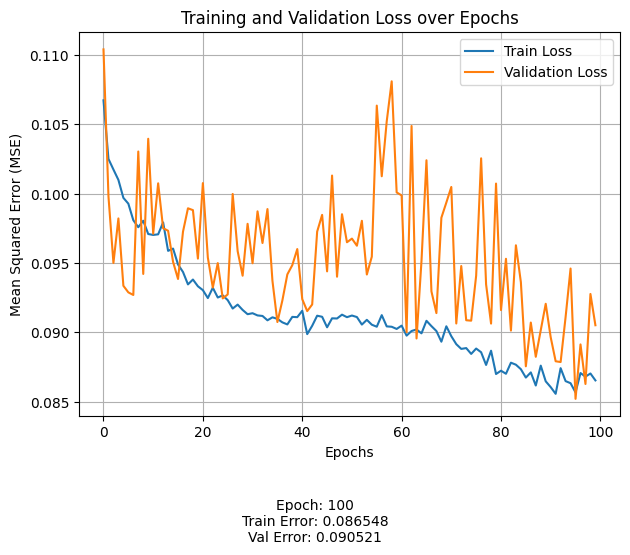

In [25]:
# training validation loss plot
# get the data
train_losses = history["train_loss"]
val_losses = history["val_loss"]
last_epoch = len(train_losses)
train_error = train_losses[-1]
val_error = val_losses[-1]
annotation_text = f"Epoch: {last_epoch}\nTrain Error: {train_error:.6f}\nVal Error: {val_error:.6f}"

# plotting
fig, ax = plt.subplots()
ax.plot(train_losses, label='Train Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Mean Squared Error (MSE)')
ax.set_title('Training and Validation Loss over Epochs')
ax.grid(True)
ax.legend()
fig.text(0.5, -0.05, annotation_text, ha='center', va='top')

plt.tight_layout()
plt.show()

In [26]:
# Predictions
model.load_state_dict(torch.load("best_model.pt"))
model.eval()
pred = []
y_buffer = torch.zeros(y_lags, device = device) # y_buffer = [0, 0]
with torch.no_grad():
    for i in range(len(Xtest)):
        x = Xtest[i]
        x_aug = torch.cat((x, y_buffer), dim=0)
        y_pred = model(x_aug)
        y_buffer = torch.cat([y_pred.detach(), y_buffer[1:]])
        pred.append(y_pred.cpu().numpy())

pred = np.array(pred)   # numpy, (1000, 1), scaled
pred = yscaler.inverse_transform(pred)

print(f"type: {type(pred)}, dim: {pred.shape}")
print(f"type: {type(T_test)}, dim: {T_test.shape}")

print(pred)
print(T_test)

mse_test = np.mean((pred - T_test)**2)
print(f"mse test: {mse_test}")

type: <class 'numpy.ndarray'>, dim: (10000, 1)
type: <class 'numpy.ndarray'>, dim: (10000, 1)
[[ 7.7698407]
 [ 7.9160056]
 [ 5.2978354]
 ...
 [ 1.1917044]
 [-5.0568724]
 [-5.2381616]]
[[ 6.50940239]
 [ 6.34573165]
 [ 4.26809649]
 ...
 [ 6.04751612]
 [-0.04208463]
 [-2.45043779]]
mse test: 8.634292251963922


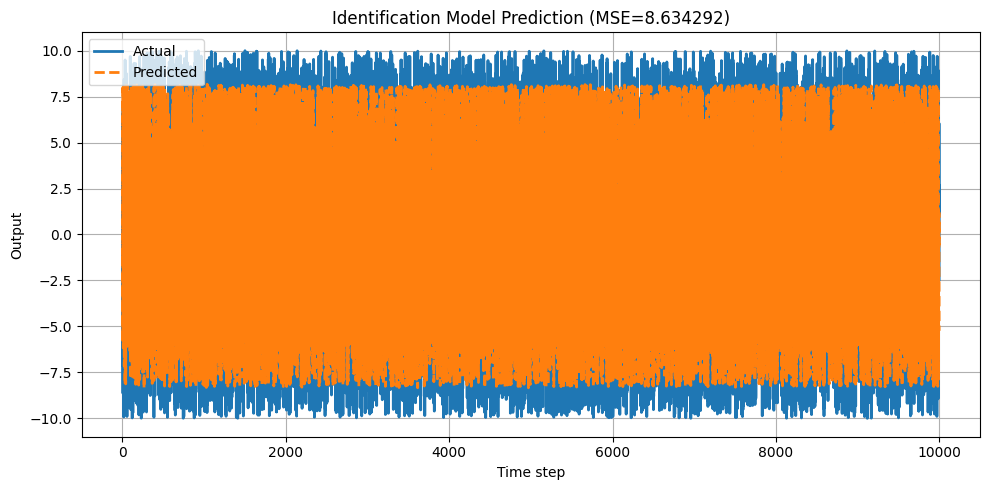

In [27]:
# Prediction vs target plot
plt.figure(figsize=(10, 5))
plt.plot(T_test, label='Actual', linewidth=2)
plt.plot(pred, label='Predicted', linestyle='--', linewidth=2)
plt.title(f'Identification Model Prediction (MSE={mse_test:.6f})')
plt.xlabel('Time step')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()